In [17]:
import cv2
import numpy as np
import pytesseract
import re
from langdetect import detect_langs
import pycountry
import matplotlib.pyplot as plt

# Машинное обучение в задачах распознавания текста
**Выполнил:** Студент группы ПИ19-3 Кузин Василий Геннадьевич

**Проверил:** Денисенко Игорь Александрович

## Предварительная обработка изображений

### Эрозия
**Эрозия** вычисляет локальный минимум в каждой области, затронутой ядром. Поскольку темные пиксели обозначаются 0, если область, перекрывающаяся ядром, содержит хотя бы один 0, все пиксели в ней будут преобразованы в 0.

In [18]:
def erode(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.erode(image, kernel, iterations = 1)

### Дилатация
В отличие от эрозии, которая определяет локальный минимум, **дилатация** определяет локальный максимум. Она имеет те же входные аргументы, что и эрозия, но здесь выходом является результат логического оператора ИЛИ, выполняемого над входным изображением и ядром.

In [19]:
def dilate(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.dilate(image, kernel, iterations = 1)

### Открытие
**Открытие** представляет собой эрозию с последующей дилатацией одного и того же элемента.

In [20]:
def opening(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

### Закрытие
**Закрытие** — это операция, аналогичная открытию. Сначала применяется дилатация, а затем эрозия над тем же структурным элементом. 

In [21]:
def closing(image):
  kernel = np.ones((3,3),np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

### Градации серого
**Преобразование к градациям серого** — это преобразование изображения из других цветовых пространств, например, RGB, CMYK, или HSV, в оттенки серого. Цвета в таком пространстве варьируются от полностью черного до полностью белого цвета.

In [22]:
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### Уменьшение шумов
На входном изображении может быть большое количество шумов, например из-за того, что оно было снято при недостаточном освещении. Для получения лучшего результата при работе с таким изображением необходимо удалить или уменьшить количество такого шума.

In [23]:
def remove_noise(image):
  return cv2.medianBlur(image,5)

### Обнаружение краев
Для лучшего распознавания текста или объектов на изображении нам часто нужно определить их края. Существует множество алгоритмов, используемых для этой задачи, но один из самых популярных — **Canny edge detection**.

In [24]:
def canny(image):
  return cv2.Canny(image, 100, 200)

### Пороговая обработка (tresholding)
**Пороговая обработка** — это техника, которая представляет собой распределение значений пикселей по отношению к заданному пороговому значению.

In [25]:
def thresholding(image):
  return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

### Коррекция наклона
Обнаружение и коррекция наклона является неотъемлемой технологией в области цифровой обработки изображений и распознавания текста. Наклон оказывает непосредственное влияние на надежность и эффективность этапов сегментации и выделения признаков для различных приложений.

In [26]:

def getSkewAngle(image) -> float:
    # Подготовка изображения
    image = thresholding(remove_noise(get_grayscale(image)))

    # Найти контуры
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Найти самый большой контур
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Вычислить угол
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

## Распознавание текста

### Предварительная обработка
Нужно провести предварительную обработку изображения, исправление наклона и так далее.

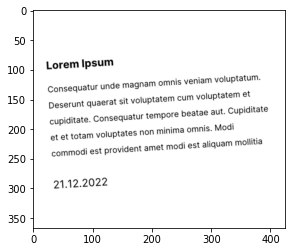

In [27]:
img = cv2.imread('Фото/Исходное изображение.png')

img = deskew(img)
cv2.imwrite('Фото/Предварительная обработка.png', img)
plt.imshow(img)

### Границы каждого символа
Используя Pytesseract, мы можем получить информацию о граничных рамках для результатов OCR. Приведенный ниже код предоставит информацию о границах для каждого символа, обнаруженного tesseract.

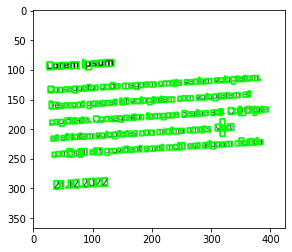

In [28]:
img_letter_boxes = img.copy()

h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img_letter_boxes) 
for b in boxes.splitlines():
    b = b.split(' ')
    img_letter_boxes = cv2.rectangle(img_letter_boxes, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2.imwrite('Фото/Границы каждого символа.png', img_letter_boxes)
plt.imshow(img_letter_boxes)

### Границы слов
Намного полезнее увидеть слова, а не отдельные символы

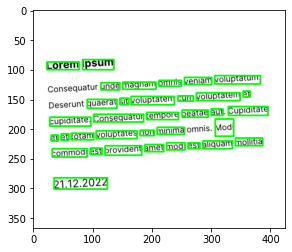

In [29]:
img_word_boxes = img.copy()

d = pytesseract.image_to_data(img_word_boxes, output_type=pytesseract.Output.DICT)

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(float(d['conf'][i])) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img_word_boxes = cv2.rectangle(img_word_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imwrite('Фото/Границы слов.png', img_word_boxes)
plt.imshow(img_word_boxes)

### Поиск по паттерну
В определенных ситуациях нам может понадобиться найти, например, дату. Так как она написана в определенном формате, мы можем использовать  шаблон регулярного выражения, который мы сопоставим с результатами OCR, чтобы найти соответствующий текстовый блок.

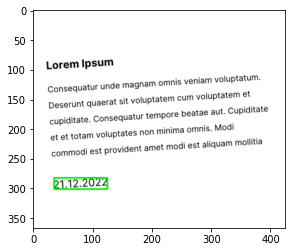

In [30]:
date_pattern = '^(0[1-9]|[12][0-9]|3[01]).(0[1-9]|1[012]).(19|20)\d\d$'

img_pattern_boxes = img.copy()

n_boxes = len(d['text'])
for i in range(n_boxes):
	if int(float(d['conf'][i])) > 60:
		if re.match(date_pattern, d['text'][i]):
				(x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
				img_pattern_boxes = cv2.rectangle(img_pattern_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imwrite('Фото/Поиск по паттерну.png', img_pattern_boxes)
plt.imshow(img_pattern_boxes)

### Определение языка текста
К сожалению, в tesseract нет функции автоматического определения языка текста на изображении. Альтернативным решением является другой python-модуль под названием `langdetect`, который можно установить с помощью pip.

Также нам необходимо дополнительно загрузить данные для тренировки в формате .traineddata.

In [31]:
img_rus = cv2.imread('Фото/Русский текст.png')

img_rus = deskew(img_rus)
custom_config = r'-l eng+rus --psm 6'
txt = pytesseract.image_to_string(img_rus, config=custom_config)

langs = detect_langs(txt)
langs

[ru:0.9999959560209403]

Далее мы должны взять распознанный язык, в котором программа наиболее уверена, и использовать его при повторном распознавании.

Модуль langdetect предоставляет нам код этого языка в формате alpha_2 (например, ru), а модулю Tesseract нужен код в формате alpha_3. Поэтому нам необходимо его преобразовать с помощью библиотеки pycountry.

In [32]:
country = pycountry.languages.get(alpha_2=langs[0].lang)
country.alpha_3

'rus'

После того, как язык был преобразован, мы можем использовать его при повторном распознавании текста.

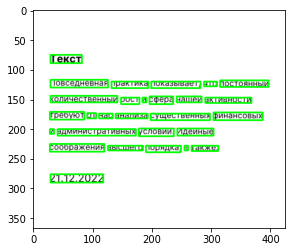

In [33]:
custom_config = r'-l ' + re.escape(country.alpha_3) + r' --psm 6'
d = pytesseract.image_to_data(img_rus, config=custom_config, output_type=pytesseract.Output.DICT)

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(float(d['conf'][i])) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img_rus = cv2.rectangle(img_rus, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imwrite('Фото/Границы русского текста.png', img_rus)
plt.imshow(img_rus)

Теперь стоит написать функцию для автоматизации всего этого процесса

In [34]:
def detect_language(image):
  custom_config = r'-l eng+rus --psm 6'
  txt = pytesseract.image_to_string(image, config=custom_config)

  langs = detect_langs(txt)
  country = pycountry.languages.get(alpha_2=langs[0].lang)
  return country.alpha_3

### Итоговое распознавание текста

In [35]:
def recognize_text(image):
  image = deskew(image)
  custom_config = r'-l ' + re.escape(detect_language(image)) + r' --psm 6'
  return pytesseract.image_to_string(image, config=custom_config)

#### На английском

In [36]:
print(recognize_text(cv2.imread('Фото/Исходное изображение.png')))

Lorem Ipsum

Consequatur unde magnam omnis veniam voluptatum.
Deserunt quaerat sit voluptatem CUM voluptatem et
cupiditate. Conseguatur tempore beatae aut. Cupiditate
et et totam voluptates non minima omnis. Modi
commodi est provident amet modi est aliquam molltia
21.12.2022



#### На русском

In [37]:
print(recognize_text(cv2.imread('Фото/Русский текст.png')))

Текст

Повседневная практика показывает, что постоянный
количественный рост и сфера нашей активности:
требуют от нас анализа существенных финансовых
‘и административных условий. Идейные
соображения высшего порядка, а также.
21.12.2022

